# Making predictions with your model

In [46]:
import sys
import argparse

import tensorflow_hub as hub
import numpy as np
import pandas as pd
import tensorflow_text
import tensorflow as tf
import glob
import logging
import sys
from tqdm import tqdm
from scipy.special import softmax

my_stderr = sys.stderr = open('errors.txt', 'w')  # redirect stderr to file
get_ipython().log.handlers[0].stream = my_stderr  # log errors to new stderr
get_ipython().log.setLevel(logging.INFO)  # errors are logged at info level

# %matplotlib inline
import os
import math
import argparse
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from sklearn.metrics import classification_report
from livelossplot import PlotLosses
import matplotlib.pyplot as plt
import mplcursors
import pickle
import ast
import seaborn as sns

import ipdb


class Net(nn.Module):
    def __init__(self, idim="{}", odim=2, nhid=None,
                 dropout=0.0, gpu=0, activation='RELU'):
        super(Net, self).__init__()
        
        idim = ast.literal_eval(idim)
        idim = sum([i for i in list(idim.values())])
        
        self.gpu = gpu
        modules = []

        modules = []
        print(' - mlp {:d}'.format(idim), end='')
        if len(nhid) > 0:
            if dropout > 0:
                modules.append(nn.Dropout(p=dropout))
            nprev = idim
            for nh in nhid:
                if nh > 0:
                    modules.append(nn.Linear(nprev, nh))
                    nprev = nh
                    if activation == 'TANH':
                        modules.append(nn.Tanh())
                        print('-{:d}t'.format(nh), end='')
                    elif activation == 'RELU':
                        modules.append(nn.ReLU())
                        print('-{:d}r'.format(nh), end='')
                    else:
                       raise Exception('Unrecognized activation {activation}')
                    if dropout > 0:
                        modules.append(nn.Dropout(p=dropout))
            modules.append(nn.Linear(nprev, odim))
            print('-{:d}, dropout={:.1f}'.format(odim, dropout))
        else:
            modules.append(nn.Linear(idim, odim))
            print(' - mlp %d-%d'.format(idim, odim))
        self.mlp = nn.Sequential(*modules)
        # Softmax is included CrossEntropyLoss !

        if self.gpu >= 0:
            self.mlp = self.mlp.cuda()

    def forward(self, x):
        return self.mlp(x)

    def TestCorpus(self, dset, name='', nlbl=2):
        correct = 0
        total = 0
        self.mlp.train(mode=False)
        corr = np.zeros(nlbl, dtype=np.int32)
        for data in dset:
            X, Y = data
            Y = Y.long()
            if self.gpu >= 0:
                X = X.cuda()
                Y = Y.cuda()
            outputs = self.mlp(X)
            _, predicted = torch.max(outputs.data, 1)
            total += Y.size(0)
            correct += (predicted == Y).int().sum()
            for i in range(nlbl):
                corr[i] += (predicted == i).int().sum()

        print(' | {:4s}: {:5.2f}%'
                         .format(name, 100.0 * correct.float() / total), end='')
        print(' | classes:', end='')
        for i in range(nlbl):
            print(' {:5.2f}'.format(100.0 * corr[i] / total), end='')

        return correct, total

    def TestCorpus_cstm(self, dset, name='', nlbl=2, txt=None):
        correct = 0
        total = 0
        self.mlp.train(mode=False)
        corr = np.zeros(nlbl, dtype=np.int32)
        
        if args.gpu >= 0:
            criterion = nn.CrossEntropyLoss().cuda()
        else:
            criterion = nn.CrossEntropyLoss()

        Y_all = torch.empty(0, dtype=torch.int64)
        predicted_all = torch.empty(0, dtype=torch.int64)
        loss_all = 0
        batches = 0
        for i, data in enumerate(dset, 0):
            X, Y = data
            Y = Y.long()
            Y_all = torch.cat((Y_all,Y))
            if self.gpu >= 0:
                X = X.cuda()
                Y = Y.cuda()
            outputs = self.mlp(X)
            _, predicted = torch.max(outputs.data, 1)
            predicted_all = torch.cat((predicted_all,predicted.cpu()))
            total += Y.size(0)
            correct += (predicted == Y).int().sum()
            for i in range(nlbl):
                corr[i] += (predicted == i).int().sum()
                
            loss_all += criterion(outputs, Y)
            batches += 1
        
        avg_loss = loss_all/float(batches)
        print(' | {:4s}: {:5.2f}%'
                         .format(name, 100.0 * correct.float() / total), end='')
        print(' | classes:', end='')
        for i in range(nlbl):
            print(' {:5.2f}'.format(100.0 * corr[i] / total), end='')
        
        clf_report = classification_report(Y_all, predicted_all, output_dict=True)
        print('\n')
        print(classification_report(Y_all, predicted_all))
        
        # Fail State Analysis
        FP = []
        FN = []
        TP = []
        if txt is not None:
            for idx, txt_label in enumerate(txt['labels']):
                assert txt_label == Y_all[idx].item(), 'Mismatched labels'
                
                # TP
                if (Y_all[idx].item() == 1) and (predicted_all[idx].item() == 1):
                    TP.append((idx, txt['text'][idx]))

                # FP
                if (Y_all[idx].item() == 0) and (predicted_all[idx].item() == 1):
                    FP.append((idx, txt['text'][idx]))
                
                # FN
                if (Y_all[idx].item() == 1) and (predicted_all[idx].item() == 0):
                    FN.append((idx, txt['text'][idx]))

            fail_state = {'TP':TP,'FP':FP,'FN':FN}
            clf_report['fail_state'] = fail_state
                    

        return correct, total, avg_loss, clf_report


def model_predict(text_list, input_np, model_path):
    model = torch.load(model_path)
    input_tnsr = torch.from_numpy(input_np)
    outputs = model.mlp(input_tnsr)
    scores = outputs.detach().numpy()
    probs = softmax(scores, axis=1)
    return [{"text": x[0], "probs": x[1]} for x in zip(text_list, probs.tolist())]    

# Notes from Brandon
- Two key params: stride length, window
- Characters as units
- Words as units
- Output needs to be some aggregation across the inputs (avg, max, min etc.)
- Works well on transcripts and chats
- Does this only solve for the long sentence problem?
- Need to map classification quality to length distro
- If the window goes too low, how do results change


In [47]:
# embed the test dataset
def USEm(txt_list, use_embedder):
    output = []
    txt_df = pd.Series(txt_list)
    batch_size = 124
    for k,g in txt_df.groupby(np.arange(len(txt_df))//batch_size):
        output.append(use_embedder(g.tolist()).numpy())
    output = np.concatenate(output, axis=0).flatten()
    output.resize(output.shape[0] // 512, 512)
    # print(output.shape)
    # print(output.min())
    # print(output.max())
    # print('\n')
    return output

In [54]:
from datetime import datetime
import re

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3")

# text_file = 'test.txt'
text_list = [
    "how do you know they did that since it was supposed to be kept quiet",
    "that was supposed to be kept quiet",
    "Cómo sabes que hicieron eso ya que se suponía que debía mantenerse en secreto",
    "conas a bhfuil a fhios agat go ndearna siad é sin ó bhí sé ceaptha é a choinneáil ciúin"
    
]
lang = 'en'
MODEL_PATH = "SECRECY-EN_best_model_test_USEm_full"
usem_np = USEm(text_list, embed)
input_np = usem_np

pos = model_predict(text_list, input_np, MODEL_PATH)

In [55]:
pos

[{'text': 'how do you know they did that since it was supposed to be kept quiet',
  'probs': [0.06536271423101425, 0.9346372485160828]},
 {'text': 'that was supposed to be kept quiet',
  'probs': [0.04950559511780739, 0.9504944086074829]},
 {'text': 'Cómo sabes que hicieron eso ya que se suponía que debía mantenerse en secreto',
  'probs': [0.012800492346286774, 0.9871994853019714]},
 {'text': 'conas a bhfuil a fhios agat go ndearna siad é sin ó bhí sé ceaptha é a choinneáil ciúin',
  'probs': [0.7971063852310181, 0.20289351046085358]}]

In [24]:
lst = "this is a very long sentence with many many words"

def sliding_window(elements, window_size, char=False):
    if char:
        if len(elements) <= window_size:
            return [elements]
        element_list = list()
        for i in range(len(elements) - window_size + 1):
            element_list.append(elements[i:i+window_size])
        return element_list
    else:
        tokenised_element = elements.split()
        if len(tokenised_element) <= window_size:
            return [elements]
        element_list = list()
        for i in range(len(tokenised_element) - window_size + 1):
            element_list.append(" ".join(tokenised_element[i:i+window_size]))
        return element_list
        
    

def model_predict(text, label, input_np, model_path):
    model = torch.load(model_path)
    input_tnsr = torch.from_numpy(input_np)
    outputs = model.mlp(input_tnsr)
    scores = outputs.detach().numpy()
    probs = softmax(scores, axis=1)
    top_prob_index = np.argmax(probs[:,1])
    return {"text": text, "prob": probs[top_prob_index, 1], "label": label, "top_prob_index": top_prob_index}

In [37]:
with open("ml-training/SECRECY-EN/data/test.txt.en", "r") as fl:
    test_data = fl.read().splitlines()

with open("ml-training/SECRECY-EN/data/test.lbl.en", "r") as fl:
    test_data_labels = fl.read().splitlines()

In [39]:
len(test_data)

34934

In [40]:
data = zip(test_data, test_data_labels)
# positives = [x for x in data if x[1] == "1"]

In [41]:
import time
start = time.time()
# chunk sentences
WINDOW_SIZE = 10
fixed_width_samples = [{"original_sample": x[0], "chunks": sliding_window(x[0], WINDOW_SIZE, char=False), "label": x[1]} for x in data]
end = time.time()
print(end - start)

0.2848930358886719


In [42]:
fixed_width_samples[:10]

[{'original_sample': 'it was all that junk from the gallbladder thats why i couldnt lose any weight',
  'chunks': ['it was all that junk from the gallbladder thats why',
   'was all that junk from the gallbladder thats why i',
   'all that junk from the gallbladder thats why i couldnt',
   'that junk from the gallbladder thats why i couldnt lose',
   'junk from the gallbladder thats why i couldnt lose any',
   'from the gallbladder thats why i couldnt lose any weight'],
  'label': '0'},
 {'original_sample': 'management reporting group enron europe limited',
  'chunks': ['management reporting group enron europe limited'],
  'label': '0'},
 {'original_sample': 'last year the colorado oil and gas conservation commission ruled that drillers could sink one well per 160 acres in parts of the county twice the previous density',
  'chunks': ['last year the colorado oil and gas conservation commission ruled',
   'year the colorado oil and gas conservation commission ruled that',
   'the colorad

In [18]:
import time
start = time.time()
test_data_predictions = list()
for sentence in fixed_width_samples:
    input_np = USEm(sentence['chunks'], embed)
    prediction = model_predict(sentence['original_sample'], sentence['label'], input_np, MODEL_PATH)
    prediction["top_hit"] = sentence["chunks"][prediction["top_prob_index"]]
    test_data_predictions.append(prediction)
end = time.time()
print(end - start)

2217.9866030216217


In [19]:
def threshold_analysis(labels, model_scores, thresholds=np.append(np.arange(0.01,0.98,0.01),np.append(np.arange(0.98,0.999,0.001),np.arange(0.999,1.0,0.00001)))):
    '''
    function for calculating classification metrics at a range of decision thresholds.
    The function will return a pandas dataframe sorted by F1 in decending order.
    '''
    #thresholds = np.arange(0.9,1.00,0.001)
    tps = [sum((labels==1) & (model_scores>=x)) for x in thresholds]
    fps = [sum((labels==0) & (model_scores>=x)) for x in thresholds]
    tns = [sum((labels==0) & (model_scores<x)) for x in thresholds]
    fns = [sum((labels==1) & (model_scores<x)) for x in thresholds]
    precision = [None if (tp+fp)==0 else tp/(tp+fp) for tp,fp in zip(tps,fps)]
    recall = [None if (tp+fn)==0 else tp/(tp+fn) for tp,fn in zip(tps,fns)]
    f1 = [None if (p==None) or (r==None) or (p+r==0) else 2*p*r/(p+r) for p,r in zip(precision, recall)]
    prcurve = pd.DataFrame({'Threshold':thresholds,'F1':f1,'Recall':recall,'Precision':precision,
                           'TP':tps,'FP':fps,'TN':tns,'FN':fns})
    prcurve = prcurve[['Threshold','F1','Recall','Precision','TP','FP','TN','FN']]
    prcurve = prcurve.sort_values(by='F1',ascending=False).reset_index(drop=True)
    return prcurve

In [20]:
y_preds = [x["prob"] for x in test_data_predictions]
threshold_analysis(
    pd.Series([1 if x != "0" else 0 for x in test_data_labels]), 
    pd.Series(y_preds)
)

,Threshold,F1,Recall,Precision,TP,FP,TN,FN
0,0.60000,0.685015,0.745011,0.633962,336,194,34289,115
1,0.59000,0.684157,0.751663,0.627778,339,201,34282,112
2,0.61000,0.683778,0.738359,0.636711,333,190,34293,118
3,0.58000,0.680723,0.751663,0.622018,339,206,34277,112
4,0.63000,0.678460,0.722838,0.639216,326,184,34299,125
...,...,...,...,...,...,...,...,...
213,0.99996,0.013216,0.006652,1.000000,3,0,34483,448
214,0.99997,0.008830,0.004435,1.000000,2,0,34483,449
215,0.99998,0.008830,0.004435,1.000000,2,0,34483,449
216,0.99999,0.004425,0.002217,1.000000,1,0,34483,450


In [23]:
# classificaton report for English
threshold = 0.6
y_pred = [1 if x >= threshold else 0 for x in y_probs]
print(classification_report(test_data_labels, y_pred))

ValueError: Mix of label input types (string and number)

In [57]:
def plot_similarity(labels, features, rotation):
    corr = np.inner(features, features)
    sns.set(font_scale=1.2)
    g = sns.heatmap(
        corr,
        xticklabels=labels,
        yticklabels=labels,
        vmin=0,
        vmax=1,
        cmap="YlOrRd"
    )
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
    message_embeddings_ = embed(messages_)
    plot_similarity(messages_, message_embeddings_, 90)

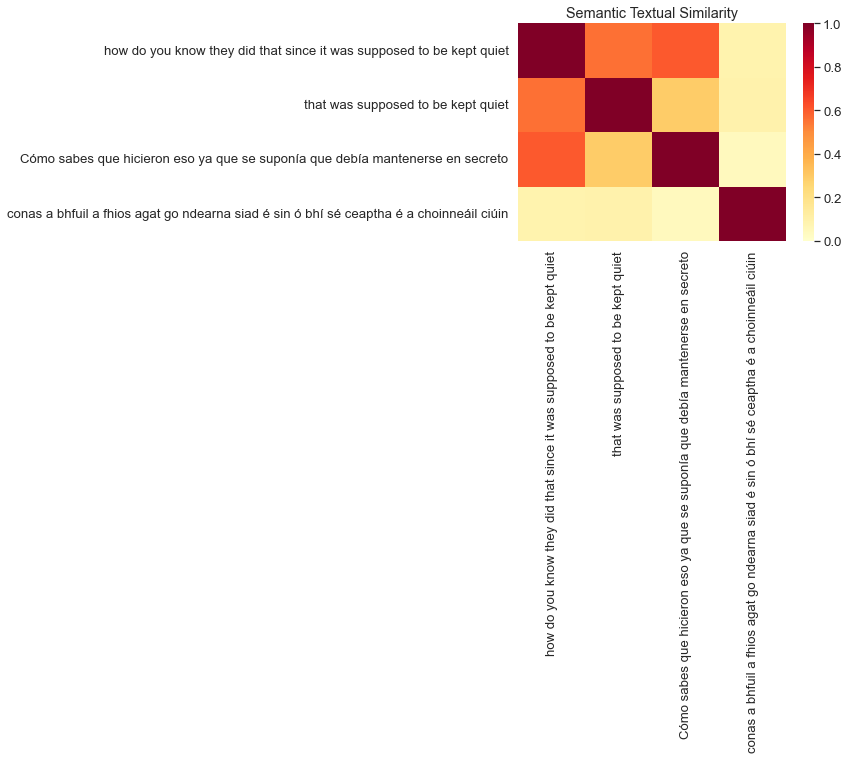

In [58]:
run_and_plot([
    "how do you know they did that since it was supposed to be kept quiet",
    "that was supposed to be kept quiet",
    "Cómo sabes que hicieron eso ya que se suponía que debía mantenerse en secreto",
    "conas a bhfuil a fhios agat go ndearna siad é sin ó bhí sé ceaptha é a choinneáil ciúin"
    
])